In [1]:
include("../../startup.jl")
using DifferentialEquations
using NumericallyIntegrateArrays
using Distributions
using LaTeXStrings
using LsqFit
using Interpolations
using JLD2
using JuliaDB

In [2]:
default(size=(600,400), grid=false, linewidth=2,
    tickfontsize=18, guidefontsize=18, legendfontsize=16, titlefontsize=20, margin=10mm)

In [24]:
@load "radiotrack.jld2" t meansd semsd stdsd
t_rt = t 
msd_rt = meansd;
sem_rt = semsd;
std_rt = stdsd;

Diffusion simulations in one and two dimensions:

In [83]:
function centreddiffusion2d!(du,u,p,t)
    D,h,n = p
    du[1] = (D/h^2)*(u[2]-u[1]) + (D/(2h^2))*(u[2]-u[1])
    for i = 2:n-1
        du[i] = (D/h^2)*(u[i-1]-2*u[i]+u[i+1]) + (D/(2i*h^2))*(u[i+1]-u[i-1])
    end
    du[n] = (D/h^2)*(u[n-1]-u[n]) + (D/(2n*h^2))*(u[n]-u[n-1])
end
    
function diffusion_sim2d(D, dt, u0, N, h, t, r)
    tspan = (0.0, dt)
    msd = [2*pi*sum(u0.*r.^3)]
    us_int = [2*pi*sum(r.*u0)]
    us = [u0]
    for (i,ts) in enumerate(t[1:(end-1)])
        prob = ODEProblem(centreddiffusion2d!,u0,tspan,(D,h,N))
        u0 = solve(prob, Euler(),dt=dt).u[end]
        append!(msd,2*pi*sum(u0.*r.^3))
        append!(us,[u0])
        append!(us_int,2*pi*sum(u0.*r))
    end
    return msd, us_int, us
end

function diffusions!(du,u,p,t)
    d,n = p
    du[1] = d*(u[2]-u[1])
    for i = 2:n-1
       du[i] = d*(u[i-1]-2*u[i]+u[i+1])
    end
    du[n] = d*(u[n-1]-u[n])
end


function diffusion_sim(d, dt, u0, N, t,x,dx)
    us = [u0]
    tspan = (0.0, dt)
    msd = [trapz(u0.*x.^2,dx)]
    for (i,ts) in enumerate(t[1:end-1])
        prob = ODEProblem(diffusions!,u0,tspan,(d,N))
        u0 = solve(prob).u[end]
        append!(msd,trapz(u0.*x.^2,dx))
        append!(us,[u0])
    end
    return msd, us
end

function convectiondiffusions!(du,u,p,t)
    d,n,c = p
    du[1] = d*(u[2]-u[1]) - c*(u[2])
    for i = 2:n-1
       du[i] = d*(u[i-1]-2*u[i]+u[i+1]) - c*(u[i+1]-u[i])
    end
    du[n] = d*(u[n-1]-u[n]) + c*(u[n])
end

function convection_diffusion_sim(d1, d2, c, dt, u0, N, t, tD, x)
    tspan = (0.0, dt)
    u0s = [u0]
    msd = [trapz(u0.*x.^2,dx)]
    for (i,ts) in enumerate(t[1:end-1]) 
        if ts < tD
            prob = ODEProblem(diffusions!,u0,tspan,(d1,N))
            u0 = solve(prob).u[end]
        else
            prob = ODEProblem(convectiondiffusions!,u0,tspan,(d2,N,c))
            u0 = solve(prob).u[end]
        end 
        append!(u0s, [u0])
        append!(msd,trapz(u0.*x.^2,dx))
    end
    return msd, u0s
end

function convectiondiffusions!(du,u,p,t)
    d,n,c = p
    du[1] = d*(u[2]-u[1]) - c*(u[2])
    for i = 2:n-1
       du[i] = d*(u[i-1]-2*u[i]+u[i+1]) - c*(u[i+1]-u[i])
    end
    du[n] = d*(u[n-1]-u[n]) + c*(u[n])
end

function convectiondiffusions2d!(du,u,p,t)
    d,n,c = p
    du[1] = (D/h^2)*(u[2]-u[1]) + (D/(2h^2))*(u[2]-u[1]) - c*(u[2])
    for i = 2:n-1
       du[i] = (D/h^2)*(u[i-1]-2*u[i]+u[i+1]) + (D/(2i*h^2))*(u[i+1]-u[i-1]) - c*(u[i+1]-u[i])
    end
    du[n] = du[n] = (D/h^2)*(u[n-1]-u[n]) + (D/(2n*h^2))*(u[n]-u[n-1]) + c*(u[n])
end

function convection_diffusion_sim2d(D, c, dt, u0, N, t, tD)
    tspan = (0.0, dt)
    u0s = [u0]
    msd = [2*pi*sum(u0.*r.^3)]
    us_int = [2*pi*sum(r.*u0)]
    for (i,ts) in enumerate(t[1:end-1]) 
        if ts < tD
            prob = ODEProblem(convectiondiffusions2d!,u0,tspan,(D,N,0))
            u0 = solve(prob).u[end]
        else
            prob = ODEProblem(convectiondiffusions2d!,u0,tspan,(D,N,c))
            u0 = solve(prob).u[end]
        end 
        append!(u0s, [u0])
        append!(msd,2*pi*sum(u0.*r.^3))
        append!(us_int,2*pi*sum(u0.*r))
    end
    return msd, u0s, us_int
end

convection_diffusion_sim2d (generic function with 2 methods)

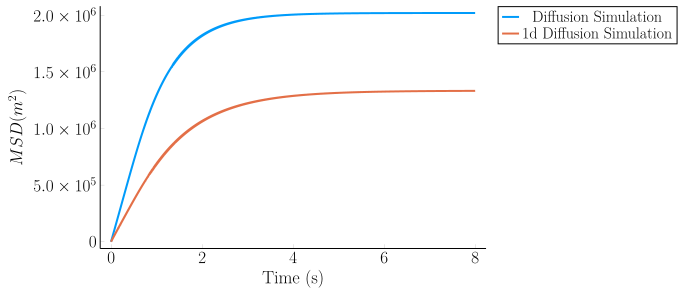

In [19]:
L = 2000
N = 100
h = L/N
D = 100#0.1h^2/2
d = D/h^2
u = zeros(N)
T = 3600*8
tD=0
dt = (0.1h^2/2D)#1 
t = dt:dt:T
dx = h
r = h:h:L
u0 = zeros(size(r))
u0[1] = 1/(2*pi*h)
u01 = zeros(size(r))
u01[1] = 1/h
tspan = (0.0, dt)

msd_diff, u_int, u =  diffusion_sim2d(D, dt, u0, N, h, t, r);
msd_diff1d,u1d = convection_diffusion_sim(d, d, 0, dt, u01, N, t, tD, r)

asymptote2d = msd_diff 
asymptote2d.= maximum(msd_diff)
asymptote1d = msd_diff1d
asymptote1d.= maximum(msd_diff1d);

p1 = plot(xlabel="Time (hours)", ylabel=L"MSD (km^2)",ylims=[0,maximum(msd_diff)./10^6])
plot!((dt:dt:T)./3600,msd_diff1d./10^6, label="1D Diffusion Simulation", ls=ls[1],color=lc[2])
plot!((dt:dt:T)./3600,msd_diff./10^6, label="2D Diffusion Simulation", ls=ls[1],color=lc[4])
plot!((dt:dt:T)./3600,2D*(dt:dt:T)./10^6, label=L"2Dt", ls=ls[2],color=lc[2])
plot!((dt:dt:T)./3600,4D*(dt:dt:T)./10^6, label=L"4Dt", ls=ls[2],color=lc[4])
plot!((dt:dt:T)./3600,asymptote2d./10^6, label="", ls=ls[3],color=lc[1], linewidth=1)
plot!((dt:dt:T)./3600,asymptote1d./10^6, label="", ls=ls[3],color=lc[1], linewidth=1)
savefig("../figs/1d2d_diffusion.png")

In [45]:
plot(xlabel=L"$r$(m)", ylabel=L"\phi")
i = 1
 plot!(u[Int(div(3600*i,dt))],label=L"$t=1$ hour",ls=ls[i],color=lc[i])
i = 2
    plot!(u[Int(div(3600*i,dt))],label=L"$t=2$ hours",ls=ls[i],color=lc[i])
i = 3
 plot!(u[Int(div(3600*i,dt))],label=L"$t=3$ hours",ls=ls[i],color=lc[i])
i = 5
 plot!(u[Int(div(3600*i,dt))],label=L"$t=5$ hours",ls=ls[i],color=lc[i])
plot!()
savefig("../figs/discretised_phi.png")

In [78]:
#
rsquared = msd_diff
rsquared.= L^2 ./2
#pgfplotsx()
p1 = plot(xlabel="Time (hours)", ylabel=L"MSD (m$^2$)",legend=:bottomright)
plot!((dt:dt:T)./3600,rsquared, label=L"R^2/2")
plot!((dt:dt:T)./3600,msd_diff, label="Diffusion Simulation")
#plot!(dt:dt:T,rsquared, label="R^2")
#plot!(dt:dt:T,msd_diff1d, label="1d Diffusion Simulation")
#plot!(dt:dt:T,4D*(dt:dt:T), label=L"4Dt")

! Dimension too large.
<recently read> \pgf@yy 
        
l.288038 \end{groupplot}
                      


ErrorException: The latex command `lualatex jl_nPsVvIlFF6.tex` failed

Diffusion simulation on a 2D shrinking domain:

In [4]:
function shrink_rate(ts,R0 )
    a = R0^2 ./ts[end]^2
    Rt2 = R0^2 .- a.*ts.^2
    Rt2[Rt2.<0] .= 0.0
    return sqrt.(Rt2)
end

function domain_shrink2d(θ, D, dt,u0, N, h, t, tD, r)
    boxsize = zeros(Int, size(t))
    boxsize[t .<= θ[2]] .= div(θ[1],h)
    boxsize[t .> θ[2]] .= Int.(ceil.(shrink_rate(t[t .> θ[2]].-θ[2],θ[1])./h))
    boxsize[boxsize.>div(θ[1],h)] .= div(θ[1],h)
    boxsize[boxsize .== 1] .= 2
    boxsize[end] = 1
    tspan = (0.0, dt)
    msd = [2*pi*sum(u0.*r.^3)]
    us_int = [2*pi*sum(r.*u0)]
    for (i,ts) in enumerate(t[1:end-1])
        if ts > tD
            ns = length(u0)
            prob = ODEProblem(centreddiffusion2d!,u0,tspan,(D,h,ns))
            u0 = solve(prob, Euler(),dt=dt).u[end]
        end
        if ts > tD
            if boxsize[i+1] < length(u0) && boxsize[i+1] < boxsize[i]
                u0[boxsize[i+1]] += sum(u0[boxsize[i+1]+1:end])
                u0 = u0[1:boxsize[i+1]]
                r = r[1:boxsize[i+1]]
            end
        end 
        append!(msd,2*pi*sum(u0.*r.^3))
        append!(us_int,2*pi*sum(u0.*r))
    end
    return msd, us_int
end


function r2_test(x1,y1,x_model,y_model)
    sstot = 0 
    ssres = 0
    for (i,xi) in enumerate(x1)
        sstot += (y1[i]-mean(y1))^2
        ssres +=  (y_model[findfirst(x -> x==xi, x_model)]-y1[i])^2
    end 
    return 1 - ssres/sstot
end

r2_test (generic function with 1 method)

Parameter sweep over possible R_0 and t_ss values:

In [59]:
N = 200
D = 65
T = t_rt[end-6]
tD = 600.0

R_0s = 1200:50:1800
t_ss = 0:1000:5000

r2 = zeros(length(R_0s),length(t_ss))
    
@time for (i,R_0) in enumerate(R_0s)
    for (j,t_s) in enumerate(t_ss)
        h = R_0/N
        dt = (0.9h^2/2D)
        r = h:h:R_0    
        u0 = zeros(size(r))
        u0[1] = 1/(2*pi*h)
        T = t_rt[end]+dt
        t = dt:dt:T
        #print(length(t), "  ")
        msds, u_int = domain_shrink2d([R_0,t_s], D, dt,u0, N, h, t, tD, r);
        itp = interpolate((t,), msds, Gridded(Linear()))
        msd_itp = [ itp(ts) for ts in t_rt]
        r2[i,j] = r2_test(t_rt,msd_rt,t_rt,msd_itp)
    end
end

@save "test.jld2" R_0s t_ss r2
r2

1107.587123 seconds (2.35 G allocations: 264.331 GiB, 8.14% gc time)


13×6 Array{Float64,2}:
  0.346675   0.389212    0.429664   0.467099    0.50147     0.532691
  0.523265   0.560303    0.594911   0.626198    0.654104    0.678557
  0.667381   0.697382    0.724533   0.748006    0.767732    0.783665
  0.775942   0.797272    0.815246   0.82913     0.838838    0.844366
  0.846003   0.856947    0.863957   0.866383    0.864136    0.857258
  0.874874   0.873655    0.86783    0.856844    0.840608    0.819221
  0.860114   0.844904    0.824323   0.797915    0.765579    0.727493
  0.79958    0.768523    0.731223   0.687336    0.63674     0.579702
  0.691349   0.642566    0.586564   0.523107    0.452059    0.373763
  0.533873   0.465477    0.388788   0.303663    0.209944    0.108056
  0.325787   0.235914    0.136564   0.0276841  -0.0909074  -0.218723
  0.066172  -0.0470198  -0.170992  -0.305647   -0.451302   -0.607363
 -0.245864  -0.384178   -0.534661  -0.697149   -0.872003   -1.05854

Load test values and plot parameter sweep and best solution:

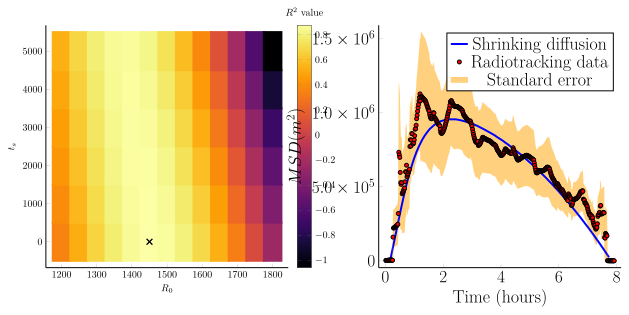

In [30]:
@load "test.jld2" R_0s t_ss r2
R_0 = R_0s[findmax(r2)[2][1]] 
t_s = t_ss[findmax(r2)[2][2]]
R_0, t_s

pgfplotsx()
#r2s = r2
#r2s[r2s.<0.8] .= 0.8
R_0 = R_0s[findmax(r2)[2][1]] 
t_s = t_ss[findmax(r2)[2][2]]
p1 = plot(size=(300,200), grid=false, linewidth=2,
    tickfontsize=10, guidefontsize=10, legendfontsize=10, titlefontsize=10, margin=10mm)
heatmap!(R_0s, t_ss, r2', match_dimensions=true, xlabel=L"R_0",ylabel=L"t_s", colorbar_title=L"$R^2$ value", label=L"$R^2$ value")#,colorbar_titlefontsize=12)
scatter!([R_0,R_0],[t_s,t_s], label="", marker=:xcross, markersize=8, color=:black)
#savefig("../figs/2dshrink_sweep.png")

R_0 = R_0s[findmax(r2)[2][1]] 
t_s = t_ss[findmax(r2)[2][2]]

h = R_0/N
dt = (0.8h^2/2D)
r = h:h:R_0      
u0 = zeros(size(r))
u0[1] = 1/(2*pi*h)
t = dt:dt:T
msds, u_int = domain_shrink2d([R_0,t_s], D, dt,u0, N, h, t, tD, r); 
p2 = plot(xlabel="Time (hours)", ylabel=L"MSD (m^2)", legend=:topright)
plot!(t[100:1000:end]./3600,msds[100:1000:end], color=:blue, label="Shrinking diffusion")
scatter!(t_rt./3600,msd_rt, color=:red, label="Radiotracking data")
plot!(t_rt./3600,msd_rt, ribbon=sem_rt, fill=:orange, linewidth=0,
    markersize=8, color=:orange, label="Standard error")
#savefig("../figs/2dshrink_result.png")

Convection-diffusion simulations:

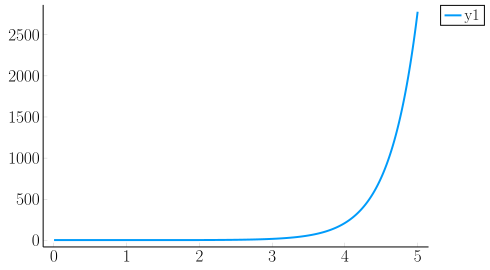

In [106]:
function convectiondiffusions2d!(du,u,p,t)
    d,n,c = p
    du[1] = (D/h^2)*(u[2]-u[1]) + (D/(2h^2))*(u[2]-u[1]) - c*(u[2])
    for i = 2:n-1
       du[i] = (D/h^2)*(u[i-1]-2*u[i]+u[i+1]) + (D/(2i*h^2))*(u[i+1]-u[i-1]) - c*(u[i+1]-u[i])
    end
    du[n] = (D/h^2)*(u[n-1]-u[n]) + (D/(2n*h^2))*(u[n]-u[n-1]) - c*(u[n])
end
msd_cd, u, u_int = convection_diffusion_sim2d(0, c, dt, u0, N, t, tD);
plot(t./3600,u_int)

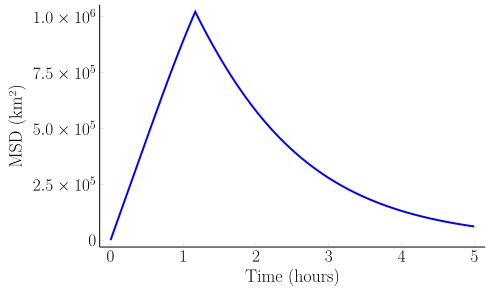

In [84]:
L = 2000
N = 100
dx = div(L,N)
D1 = 100
d1 = D1/dx^2
u = zeros(N)
tD = 4200
T = 3600*5
dt = 10.0
D2 = 100
d2 = D2/dx^2
chi = - 0.15
c = chi/dx
x = dx:dx:L
u0 = zeros(size(x))
u0[1] = 1/(2*pi*h)
tspan = (0.0, dt)
t = dt:dt:T
msd_cd, u, u_int = convection_diffusion_sim2d(D1, c, dt, u0, N, t, tD);
plot(t./3600,msd_cd, label="",xlabel="Time (hours)", ylabel="MSD (km²)", color=:blue)

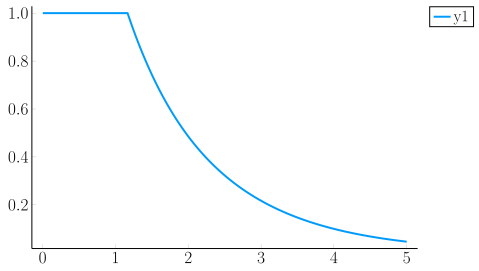

In [85]:
plot(t./3600,u_int)

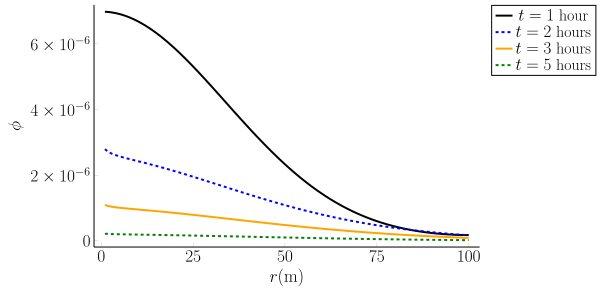

In [86]:
plot(t./3600,msd_cd, label="",xlabel="Time (hours)", ylabel="MSD (km²)", color=:blue)
#savefig("../figs/convection_diffusion_msd.png")


plot(xlabel=L"$r$(m)", ylabel=L"\phi")
i = 1
 plot!(u[Int(div(3600*i,dt))],label=L"$t=1$ hour",ls=ls[i],color=lc[i])
i = 2
    plot!(u[Int(div(3600*i,dt))],label=L"$t=2$ hours",ls=ls[i],color=lc[i])
i = 3
 plot!(u[Int(div(3600*i,dt))],label=L"$t=3$ hours",ls=ls[1],color=lc[i])
i = 5
 plot!(u[Int(div(3600*i,dt))],label=L"$t=5$ hours",ls=ls[2],color=lc[i])
plot!()
#savefig("../figs/convection_diffusion_phi.png")

In [8]:
L = 2000
N = 100
dx = div(L,N)
D1 = 63.4
d1 =D1/dx^2
u = zeros(N)
tD = 4200
T = 3600*4
dt = 10.0
D2 = 40.0
d2 = D2/dx^2
chi = - 0.15
c = chi/dx
#IC is solution to diffusion equation at time T

x = dx:dx:L
u0 = zeros(size(x))
u0[1] = 1/dx
tspan = (0.0, dt)

#msd_diff =  diffusion_sim(d1, dt, u0, N, dt:dt:T)
msd_cd,u0s = convection_diffusion_sim(d1, d2, c, dt, u0, N,dt:dt:T, tD)
#plot(xlabel=xlabel=L"$t$ (hours)", ylabel=L"MSD (km$^2$)")
#plot!((dt:dt:T)./3600,msd_cd./1e6,label="", linewidth=2)
#savefig("../figs/convection_diffusion_MSD.png")

MethodError: MethodError: no method matching convection_diffusion_sim(::Float64, ::Float64, ::Float64, ::Float64, ::Array{Float64,1}, ::Int64, ::StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}, ::Int64)
Closest candidates are:
  convection_diffusion_sim(::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, !Matched::Any) at In[3]:59

In [113]:
plot(xlabel=L"$r$ (m)",ylabel=L"\phi")
plot!(u0s[360],label=L"$t = 0$ hours")
plot!(u0s[360+72],label=L"$t = 0.2$ hours")
#plot!(u0s[360+180],label=L"$t = 0.5$ hours")
plot!(u0s[360+2*360],label=L"$t = 2$ hours")
plot!(u0s[2880],label=L"$t = 8$ hours")
savefig("../figs/convection_diffusion.png")

In [21]:
function shrink_rate(ts,R0 )
    a = R0^2 ./ts[end]^2
    Rt2 = R0^2 .- a.*ts.^2
    Rt2[Rt2.<0] .= 0.0
    return sqrt.(Rt2)
end

function domain_shrink(θ, d, dt,u0, t, tD)
    u0s = [u0]
    boxsize = zeros(Int, size(t))
    #print("t_rt = ", t_rt, "\n\n θ[2] = ", θ[2])
   # print(θ[2])
    boxsize[t .<= θ[2]] .= L/dx
   # print(boxsize)
    boxsize[t .> θ[2]] .= Int.(ceil.(shrink_rate(t[t .> θ[2]].-θ[2],θ[1])./dx))
    boxsize[boxsize.>L/dx] .= L/dx
    boxsize[end] = 1
  #  print(boxsize)
    tspan = (0.0, dt)
    msd = [trapz(u0.*x[1:size(u0)[1]].^2,dx)]
    for (i,ts) in enumerate(t[1:end-1])
      #  print(i,"\n")
        if ts > tD
            ns = length(u0)
            prob = ODEProblem(diffusions!,u0,tspan,(d,ns))
            u0 = solve(prob).u[end]
        end
        append!(msd,trapz(u0.*x[1:length(u0)].^2,dx))

        if ts > tD
            if boxsize[i+1] < length(u0) && boxsize[i+1] < boxsize[i]
                u0[boxsize[i+1]] += sum(u0[boxsize[i+1]+1:end])
                u0 = u0[1:boxsize[i+1]]
            end
        end 
        append!(u0s, [u0])
    end
    return msd, u0s
end

domain_shrink (generic function with 1 method)

In [22]:
L = 2000
N = 1000
dx = div(L,N)
D = 63.4#5062.87
d = D/dx^2
u = zeros(N)
T = t_rt[end]
dt = 10.0#100.0
tD = 00.0

#IC is solution to diffusion equation at time T

x = dx:dx:L
u0 = zeros(size(x))
u0[1] = 1/dx


prior = [Uniform(2.5e6,4e6), Uniform(0.0,7.2e3)]
R_0 = 1755.6
t_s = 901
@time msds, u0s = domain_shrink([R_0,t_s],d,dt,u0,dt:dt:T,tD);

UndefVarError: UndefVarError: t_rt not defined

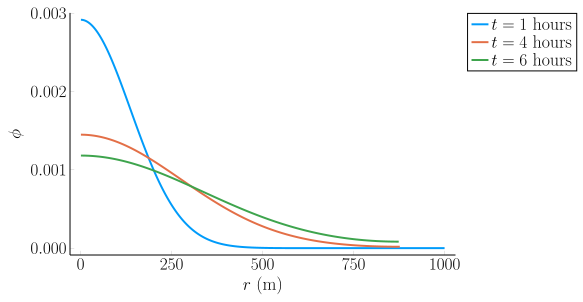

In [75]:
pgfplotsx()
plot(xlabel=L"$r$ (m)",ylabel=L"\phi")
plot!(u0s[60], label=L"$t = 1$ hours")
plot!(u0s[240], label=L"$t = 4$ hours")
plot!(u0s[360], label=L"$t = 6$ hours")

In [90]:
@load "shrink_bound.jld2" t_rt msds 

2-element Array{Symbol,1}:
 :t_rt
 :msds

Plot comparison of convection-diffusion and shrinking domain with radiotracking data:

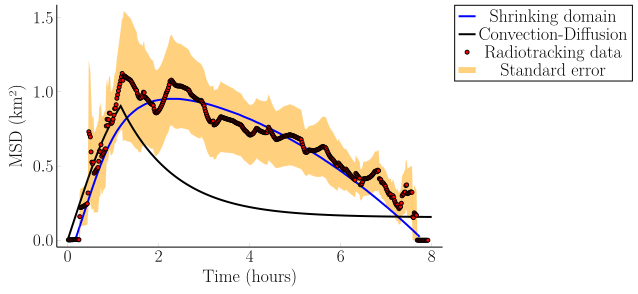

In [44]:
p1 = plot(xlabel="Time (hours)",ylabel="MSD (km²)")
plot!(t[100:1000:end]./3600,msds[100:1000:end]./1e6, color=:blue, label="Shrinking domain")
plot!((10:10:28800)./3600,msd_cd./1e6, color=:black, label="Convection-Diffusion")
scatter!(t_rt./3600,msd_rt./1e6, color=:red, label="Radiotracking data")
plot!(t_rt./3600,msd_rt./1e6, ribbon=sem_rt./1e6, fill=:orange, linewidth=0,
    markersize=8, color=:orange, label="Standard error")
savefig("../figs/msd_comparison.png")
plot(p1)